# Result

**[The embedder I had trained]**


1.   keras.layers.embedding
2.   FastText

**[The model I choose]**


1.   SVM
2.   Bidirection RNN

**[Test Accuracy比較]**
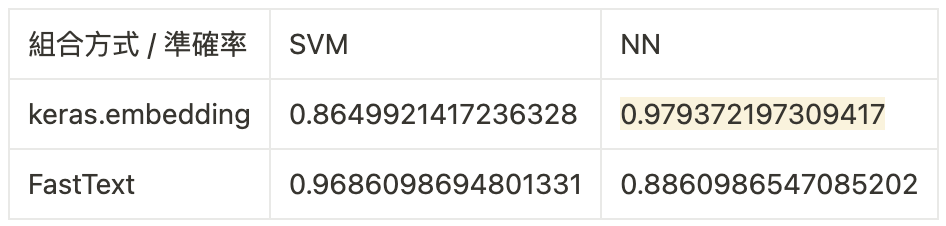




In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393377 sha256=4bf690f892364715a610958073babc11caac21df4cb84650e9a9ca14e1240081
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras import losses
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Set the FastText word embeddings path
# fasttext_path = '/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/fasttext/wiki.en.bin'

## Load text

In [ ]:
import csv

with open('/content/drive/MyDrive/Colab Notebooks/資料安全的資訊科學/smsspamcollection/SMSSpamCollection', 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    fields = line.strip().split('\t')  # 以tab分隔
    data.append(fields)


In [ ]:
data[0]

['ham',
 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']

In [ ]:
for text in range(0,2):
  print(data[text][1])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...


In [ ]:
with open('/content/output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['label', 'text'])
    for row in data:
        writer.writerow(row)

with open('/content/training_data.txt', 'w') as file:
    for i in range(len(data)):
        file.write(data[i][1] + '\n')

In [ ]:
import pandas as pd
df = pd.read_csv('/content/output.csv')
label_count = df['label'].nunique()
print(label_count)
# 將dataframe label欄位中，ham標示為1，spam標示為0
df['label'] = df['label'].replace({'ham': 1, 'spam': 0})

2


In [ ]:
df.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
text_tensor = tf.convert_to_tensor(df['text'].values)
labels_tensor = tf.convert_to_tensor(df['label'].values)
dataset = tf.data.Dataset.from_tensor_slices((text_tensor, labels_tensor))
print(len(dataset))

5574


In [ ]:
total_samples = len(dataset)

train_ratio = 0.8
test_ratio = 0.2

# 計算樣本數
train_size = int(train_ratio * total_samples)
test_size = int(test_ratio * total_samples)

# 分割資料集
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## TextVectorization layer
在訓練keras embedding之前的資料前處理
1. 將training data只包含text的資料拿到TextVectorization用
2. 會根據text的資料得到字典
3. 將每一筆training data的text部分根據字典做Vectorize，training data的label部分仍持續保留

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset_for_RNN = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset_for_RNN = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_dataset_for_RNN.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  hurry
 313 --->  into
Vocabulary size: 8552


In [ ]:
voc_size = len(vectorize_layer.get_vocabulary())

In [ ]:
len(train_text)

70

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
vectorized_train_ds = train_dataset_for_RNN.map(vectorize_text)
vectorized_test_ds = test_dataset_for_RNN.map(vectorize_text)

In [ ]:
for a, b in vectorized_train_ds.take(1):
  '''print('texts: ', a)'''
  print('labels: ', b)

labels:  tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1], shape=(64,), dtype=int64)


In [ ]:
len(vectorized_test_ds)

18

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
vectorized_test_ds = vectorized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Tokenized Data
在用FastText訓練之前的資料前處理
1. 將data tokenize
2. 移除不是字母的字
3. 計算整個資料集的大小：有幾個句子
4. 計算不重複的字有幾個
5. 計算總共有幾個字

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

file_path = '/content/training_data.txt'

with open(file_path, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_mail(mail):

    mail = re.sub(r'[^a-zA-Z0-9\s]', '', mail)
    tokens = word_tokenize(mail)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Convert the words to lowercase
    tokens = [word.lower() for word in tokens]

    return tokens

In [ ]:
tokenized_data = [preprocess_mail(sentence) for sentence in data]
print(tokenized_data)

In [ ]:
len(tokenized_data)

5574

In [ ]:
from collections import Counter
# Create a vocabulary using Counter and enumerate
vocabulary = {word: idx for idx, (word, _) in enumerate(Counter([word for sublist in tokenized_data for word in sublist]).most_common())}

count_unique_words = len(vocabulary)
print(vocabulary)
print(count_unique_words) # vocab size

In [ ]:
tokens_number = 0
for td in tokenized_data:
  tokens_number += len(td)
print(tokens_number)

52609


## Train FastText Model

In [ ]:
import fasttext
meta_hyper = {
    "vector_size": 16, # size of embedding
    "alpha": 0.025, # learning rate
    "window": 5,
    "min_freq" : 5,
    "epochs": 300, # number of training epochs
    "vocab_size": count_unique_words, #size of vocabulary
    "data_description": "This dataset contains a colleciton of SMS mails",
    "data_size": len(tokenized_data),
    "tokens_number": tokens_number,
    "CPU": 8
}

In [ ]:
from gensim.models import FastText

embed_model = FastText(vector_size=meta_hyper['vector_size'],
                       window=meta_hyper['window'],
                       min_count = meta_hyper['min_freq'],
                       alpha= meta_hyper['alpha'],
                       workers=meta_hyper['CPU'])

embed_model.build_vocab(tokenized_data)

import time
start = time.time()

embed_model.train(tokenized_data, total_examples=len(tokenized_data), epochs=meta_hyper['epochs'])

end = time.time()

embed_model.save('fasttext_{}.mdl'.format(meta_hyper['vector_size']))

In [ ]:
embed_model.wv['ok']

array([-1.039062  , -2.366051  ,  1.9173133 , -0.2413381 , -2.1006384 ,
        2.9639585 , -0.71872264, -2.607423  ,  0.9831989 ,  3.1601467 ,
        2.7265637 ,  1.8784413 ,  0.9256695 , -1.6074212 , -0.66352147,
       -1.1301205 ], dtype=float32)

In [ ]:
most_similar = embed_model.wv.most_similar('crazy')
print(most_similar)

[('mr', 0.7113990187644958), ('wap', 0.707506537437439), ('facebook', 0.6882685422897339), ('pilates', 0.6793628334999084), ('ringtone', 0.663817822933197), ('none', 0.6472043991088867), ('book', 0.6449149250984192), ('game', 0.6350132822990417), ('ringtones', 0.6223922371864319), ('lazy', 0.6117868423461914)]


In [ ]:
similarity = embed_model.wv.similarity('crazy', 'exciting')
print(similarity)

0.55761766


## Create the NN model
word embedder : keras.embedding

In [ ]:
embedding_layer = tf.keras.layers.Embedding(max_features + 1, 16)

model_NN = tf.keras.Sequential([
  embedding_layer,
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

In [ ]:
model_NN.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
history = model_NN.fit(
    vectorized_train_ds,
    validation_data=vectorized_test_ds,
    epochs=3)

Epoch 1/3
70/70 [==============================] - 2s 21ms/step - loss: 0.6183 - binary_accuracy: 0.8444 - val_loss: 0.5451 - val_binary_accuracy: 0.8650
Epoch 2/3
70/70 [==============================] - 1s 19ms/step - loss: 0.4889 - binary_accuracy: 0.8650 - val_loss: 0.4385 - val_binary_accuracy: 0.8650
Epoch 3/3
70/70 [==============================] - 1s 18ms/step - loss: 0.4141 - binary_accuracy: 0.8650 - val_loss: 0.3932 - val_binary_accuracy: 0.8650


In [ ]:
loss, accuracy = model_NN.evaluate(vectorized_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

70/70 [==============================] - 0s 2ms/step - loss: 0.3932 - binary_accuracy: 0.8650
Loss:  0.39319536089897156
Accuracy:  0.8649921417236328


In [ ]:
import numpy as np
sample_text = ('I love you')

predictions = model_NN.predict(vectorize_layer(np.array([sample_text])))
print(predictions)

1/1 [==============================] - 0s 371ms/step
[[1.5319371]]


## Create the SVM model
word embedder : keras.embedding

In [ ]:
print(embedding_layer.get_weights()[0].shape)

(10001, 16)


In [ ]:
keras_embedding_matrix = embedding_layer.get_weights()[0]
print(keras_embedding_matrix)

[[-0.18932475 -0.15575138  0.14945737 ...  0.10312102  0.16497509
   0.20105033]
 [-0.01169783  0.02626014 -0.02157244 ...  0.0318349   0.01621086
   0.01064086]
 [-0.04508197  0.00725683 -0.00092226 ... -0.01338094  0.00424129
   0.03564775]
 ...
 [ 0.02548123  0.02289467 -0.04114724 ... -0.0183509   0.02694759
  -0.03488972]
 [-0.0255649  -0.00671517 -0.03853699 ... -0.0272015  -0.01209438
   0.01553524]
 [ 0.03205905 -0.03931854  0.02781161 ...  0.01906595  0.04852492
   0.03830612]]


X_train_svm : numerical data, 要是encoding之後
所以每一筆的shape : (1, 16*25)

y_train_svm : label of training data

In [ ]:
len(dataset)

5574

In [ ]:
vectorized_dataset_for_SVM = dataset.map(vectorize_text)
print(vectorized_dataset_for_SVM)

<_MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
def encoding_layer(sentence, label):
  encoding_text = embedding_layer(sentence)
  encoding_text_flat = tf.reshape(encoding_text, [-1])
  return encoding_text_flat, label

In [ ]:
encoding_text_dataset_svm = vectorized_dataset_for_SVM.map(encoding_layer)

In [ ]:
encoding_text_for_svm = []
label_for_svm = []
for a, b in encoding_text_dataset_svm:
  encoding_text_for_svm.append(a.numpy())
  label_for_svm.append(b.numpy())

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(encoding_text_for_svm)
y = np.array(label_for_svm)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC

svm_1 = SVC()
svm_1.fit(X_train, y_train)

SVC()

In [ ]:
# Make predictions on the test data
y_pred_1 = svm_1.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_1)
print("Accuracy:", accuracy)

Accuracy: 0.979372197309417


## Create the NN model
word embedder : FastText


In [ ]:
embedding_matrix = np.zeros((count_unique_words, 16))
# 按順序取出鍵
keys = list(vocabulary.keys())
for word in keys:
  if word in vocabulary:
    embedding_matrix[vocabulary[word]] = embed_model.wv[word]

In [ ]:
text_indices = np.zeros(count_unique_words)
print(type(text_indices))

<class 'numpy.ndarray'>


In [ ]:
def encoder(sentence):
  text_indices = np.zeros(count_unique_words)
  for i in range(len(sentence)):
    text_indices[i] = vocabulary[sentence[i]]
  return text_indices

In [ ]:
encoded_data = np.zeros((len(tokenized_data), count_unique_words))
encoded_data = [encoder(sentence) for sentence in tokenized_data]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=count_unique_words,
        output_dim=16,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False  # Set to False to freeze the embeddings
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          151072    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              41472     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 200,865
Trainable params: 49,793
Non-trainable params: 151,072
_________________________________________________________________


In [ ]:
Label = []
for text_batch, label_batch in dataset:
  Label.append(label_batch.numpy())

In [ ]:
print(Label)
print(len(Label))

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(encoded_data)
y = np.array(Label)  # Assuming you have the corresponding labels for the spam data

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/3
140/140 [==============================] - 1577s 11s/step - loss: 0.2480 - accuracy: 0.9592 - val_loss: 0.2165 - val_accuracy: 0.9749
Epoch 2/3
140/140 [==============================] - 1478s 11s/step - loss: 0.1618 - accuracy: 0.9832 - val_loss: 0.6781 - val_accuracy: 0.8960
Epoch 3/3
35/35 [==============================] - 110s 3s/step - loss: 0.2463 - accuracy: 0.9686
Test Loss: 0.2462596744298935
Test Accuracy: 0.9686098694801331


## Create the SVM model
word embedder : FastText

X 要是5574筆資料，每筆資料要維度都相同的向量

In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

SVC()

In [ ]:
# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8860986547085202
